In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
import libpysal as ps
from spreg import OLS, ML_Lag, ML_Error, GM_Lag 
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from esda.moran import Moran, Moran_Local
from spreg import OLS, ML_Lag, ML_Error
import warnings
import libpysal as lp
from scipy.stats import chi2

warnings.filterwarnings("ignore")

In [2]:
from data_preparation import listings_gdf, pm_gdf

All neighbourhoods match
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'max

Global Moran's I Results
Moran's I Statistic: 0.1751
P-value: 0.0010


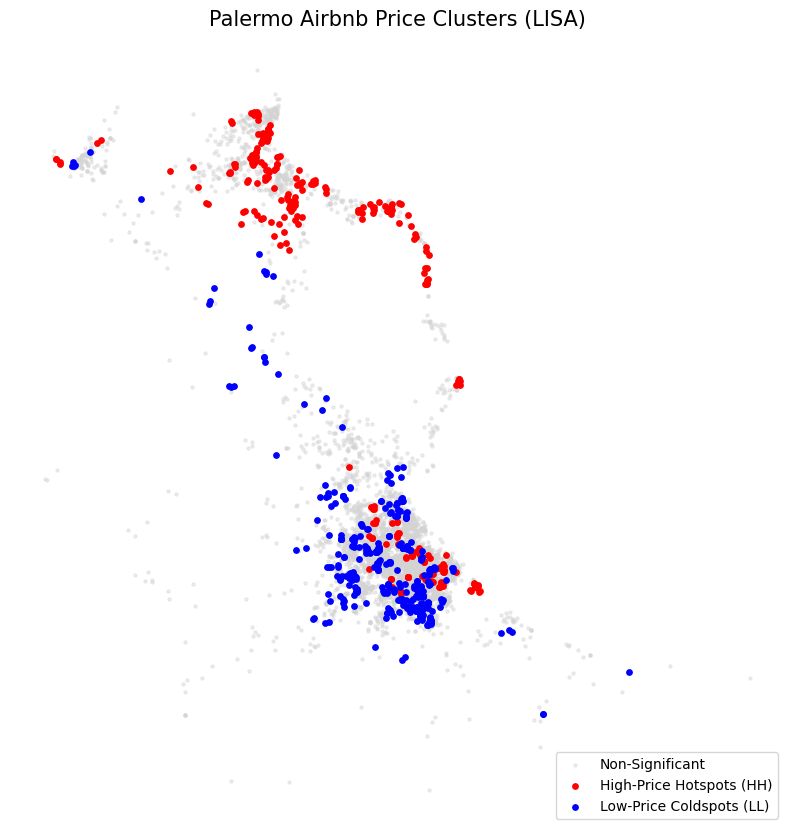

In [22]:
# 1. Create Spatial Weights Matrix (K-Nearest Neighbors = 5)
# We project to UTM 33N (32633) for accurate distance math in meters
w_k = lp.weights.KNN.from_dataframe(pm_gdf.to_crs(epsg=4326), k=5)
w_k.transform = 'r'

y = pm_gdf['log_price'].values
moran = Moran(y, w_k)

print(f"Global Moran's I Results")
print(f"Moran's I Statistic: {moran.I:.4f}")
print(f"P-value: {moran.p_sim:.4f}")

lisa = Moran_Local(y, w_k)

fig, ax = plt.subplots(figsize=(10, 12))

pm_gdf.plot(ax=ax, color='lightgrey', markersize=5, alpha=0.4, label='Non-Significant')

# High-High Clusters (Hotspots)
pm_gdf[(lisa.p_sim <= 0.05) & (lisa.q == 1)].plot(
    ax=ax, color='red', markersize=15, label='High-Price Hotspots (HH)')

# Low-Low Clusters (Coldspots)
pm_gdf[(lisa.p_sim <= 0.05) & (lisa.q == 3)].plot(
    ax=ax, color='blue', markersize=15, label='Low-Price Coldspots (LL)')

ax.set_title("Palermo Airbnb Price Clusters (LISA)", fontsize=15)
ax.legend(loc='lower right')
plt.axis('off')

plt.savefig('images/palermo_lisa_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Alternative distance based approach TODO: fine tune alpha
# coordinates and initial data
coords = np.column_stack((pm_gdf.geometry.x, pm_gdf.geometry.y))
y = pm_gdf['log_price'].values.reshape((-1, 1))
X_vars = ['accommodates', 'number_of_reviews', 'review_scores_rating', 'bedrooms']
X = pm_gdf[X_vars].values

# critical Threshold to ensure 0 islands
dist_threshold = ps.weights.min_threshold_distance(coords)

# distance band weights 
# this accounts for distance decay: closer neighbors influence price more
w_d = ps.weights.DistanceBand.from_array(coords, threshold=dist_threshold, binary=False, alpha=-2.0)
w_d.transform = 'r'

print(f"Spatial Setup Complete.")
print(f"Distance Threshold: {dist_threshold:.2f} meters | Islands: {len(w_d.islands)}")

Spatial Setup Complete.
Distance Threshold: 0.02 meters | Islands: 0


In [ ]:
model_ols = OLS(y, X, w=w_k, spat_diag=False, name_y='log_price', name_x=X_vars)

print("OLS results:")
print(f"AIC: {model_ols.aic:.2f}")
print(f"Adjusted R-Squared: {model_ols.ar2:.3f}")
# Note: Check 'Prob' of Moran's I in the summary to prove spatial bias exists

--- OLS RESULTS ---
AIC: 9037.53
Adjusted R-Squared: 0.225


In [23]:
# Maximum Likelihood Spatial Lag
model_sar = ML_Lag(y, X, w=w_k, name_y='log_price', name_x=X_vars)

for attr in ['logll', 'aic', 'schwarz']:
    val = getattr(model_sar, attr)
    if isinstance(val, np.ndarray): setattr(model_sar, attr, float(val.item()))

print("SAR results")
print(f"AIC: {model_sar.aic:.2f}")
print(f"Spatial Autoregressive Coeff (Rho): {float(model_sar.rho):.4f}")

SAR results
AIC: 8723.22
Spatial Autoregressive Coeff (Rho): 0.3036


In [16]:
# manually create the Spatially Lagged X variables 
X_lagged = ps.weights.spatial_lag.lag_spatial(w_d, X)
X_sdm = np.hstack([X, X_lagged])
names_sdm = X_vars + [f"W_{name}" for name in X_vars]

model_sdm = ML_Lag(y, X_sdm, w=w_k, name_y='log_price', name_x=names_sdm)

for attr in ['logll', 'aic', 'schwarz']:
    val = getattr(model_sdm, attr)
    if isinstance(val, np.ndarray): setattr(model_sdm, attr, float(val.item()))

print("SDM results ")
print(f"AIC: {model_sdm.aic:.2f}")
print(f"Rho (Spatial Spillover): {float(model_sdm.rho):.4f}")
print("\nModel Summary:")
print(model_sdm.summary)

SDM results 
AIC: 8721.91
Rho (Spatial Spillover): 0.2997

Model Summary:
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        5571
Mean dependent var  :      4.4024                Number of Variables   :          10
S.D. dependent var  :      0.6184                Degrees of Freedom    :        5561
Pseudo R-squared    :      0.2813
Spatial Pseudo R-squared:  0.2339
Log likelihood      :  -4350.9551
Sigma-square ML     :      0.2750                Akaike info criterion :    8721.910
S.E of regression   :      0.5244                Schwarz criterion     :    8788.164

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     P

In [19]:
# get Log-Likelihoods
ll_sdm = model_sdm.logll
ll_sar = model_sar.logll

# lr statistics
lr_stat = 2 * (ll_sdm - ll_sar)

# p-value
# df is the number of 'W_' variables you added TODO: check
p_val = chi2.sf(lr_stat, df=4)

print(f"LR Statistic: {lr_stat:.4f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("Reject H0: SDM is significantly better than the SAR.")
else:
    print("Fail to reject H0: SDM can be reduced to the SAR.")

LR Statistic: 4.9695
p-value: 0.2904
Fail to reject H0: SDM can be reduced to the SAR.


In [ ]:
# complete sar results
print("="*60)
print("SAR results:")
print("="*60)
print(model_sar.summary)

print("\n" + "-"*30)
print(f"OLS Log-Likelihood: {model_ols.logll:.4f} | AIC: {model_ols.aic:.2f}")
print(f"SAR Log-Likelihood: {model_sar.sar_logll if hasattr(model_sar, 'sar_logll') else model_sar.logll:.4f} | AIC: {model_sar.aic:.2f}")
print("-"*30)

SAR results:
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        5571
Mean dependent var  :      4.4024                Number of Variables   :           6
S.D. dependent var  :      0.6184                Degrees of Freedom    :        5565
Pseudo R-squared    :      0.2811
Spatial Pseudo R-squared:  0.2328
Log likelihood      :  -4353.4399
Sigma-square ML     :      0.2750                Akaike info criterion :    8718.880
S.E of regression   :      0.5244                Schwarz criterion     :    8758.632

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------------